Import Section

In [29]:
#Imports
import gym
import numpy as np
import random
from IPython.display import clear_output
import progressbar

import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape


from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import History

import math

#Create Gym
from gym import wrappers
envCartPole = gym.make('CartPole-v1')
envCartPole.seed(50) #Set the seed to keep the environment consistent across runs
nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions


Parameters Tuning and Help Functions

In [30]:
#Global Variables
EPISODES = 500
TRAIN_END = 0

#Hyper Parameters
def discount_rate(): #Gamma
    return 0.95

def learning_rate(): #Alpha
    return 0.001

def batch_size(): #Size of the batch used in the experience replay
    return 24

DQN networl implementation 

In [31]:
class DeepQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon,epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.actions_listed = []
        self.loss = []
        
    def build_model(self):
        model = keras.Sequential() #linear stack of layers https://keras.io/models/sequential/
        model.add(keras.layers.Dense(24, input_dim=self.nS, activation='relu')) #[Input] -> Layer 1
        #   Dense: Densely connected layer https://keras.io/layers/core/
        #   24: Number of neurons
        #   input_dim: Number of input variables
        #   activation: Rectified Linear Unit (relu) ranges >= 0
        model.add(keras.layers.Dense(24, activation='relu')) #Layer 2 -> 3
        model.add(keras.layers.Dense(self.nA, activation='linear')) #Layer 3 -> [output]
        #   Size has to match the output (different actions)
        #   Linear activation on the last layer
        model.compile(loss='mean_squared_error', #Loss function: Mean Squared Error
                      optimizer=keras.optimizers.Adam(lr=self.alpha)) #Optimaizer: Adam (Feel free to check other options)
        return model
    def save_model(self):

        self.model.save("my_model")
        print("-------- Model Saved ----")
    def load_model(self):
        return keras.models.load_model("my_model")
        print("--------- Model Loaded ------------ ")
       
    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA) #Explore
        action_vals = self.model.predict(state) #Exploit: Use the NN to predict the correct action from this state
        self.actions_listed.append(action_vals)
        return np.argmax(action_vals[0])

    def test_action(self, state): #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, batch_size):
        #Execute the experience replay
        minibatch = random.sample( self.memory, batch_size ) #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nS)) #States
        nst = np.zeros( (0,self.nS) )#Next States
        for i in range(len(np_array)): #Creating the state and next state np arrays
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)
        st_predict = self.model.predict(st) #Here is the speedup! I can predict on the ENTIRE batch
        nst_predict = self.model.predict(nst)
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
            else:   #Non terminal
                target = reward + self.gamma * np.amax(nst_action_predict_model)
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1 #Epochs is the number or iterations
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append( hist.history )
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

Creat Agent FOR DQN

In [32]:
#Create the agent
nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions
dqn = DeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.001, 0.995 )

batch_size = batch_size()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


train the DQN 

In [33]:
#Training
rewards = [] #Store rewards for graphing
epsilons = [] # Store the Explore/Exploit
TEST_Episodes = 0
game_score_history = []
reward_per_action = {"0":[],"1":[],"2":[],"3":[]}
for e in range(EPISODES):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS]) # Resize to store in memory to pass to .predict
    tot_rewards = 0
    done = False
    game_score = 0
    while not(done): #200 is when you "solve" the game. This can continue forever as far as I know
        action = dqn.action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
        game_score += 1
        #done: CartPole fell. 
        #time == 209: CartPole stayed upright
        if done :
            game_score_history.append(game_score)
            reward_per_action[str(action)].append(tot_rewards)
        
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            print("episode: {}/{}, reward: {}, e: {}  Game Score: {}"
                  .format(e, EPISODES, tot_rewards, dqn.epsilon,game_score))
            break
        #Experience Replay
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)

    #If our current NN passes we are done
    #I am going to use the last 5 runs
    if e % 25 == 0:
      dqn.save_model()
    if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
        #Set the rest of the EPISODES for testing
        TEST_Episodes = EPISODES - e
        TRAIN_END = e
        break

episode: 0/500, reward: 24.0, e: 1  Game Score: 24
INFO:tensorflow:Assets written to: my_model/assets
-------- Model Saved ----


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


episode: 1/500, reward: 11.0, e: 0.9511101304657719  Game Score: 11
episode: 2/500, reward: 13.0, e: 0.8955869907338783  Game Score: 13
episode: 3/500, reward: 20.0, e: 0.8142285204175609  Game Score: 20
episode: 4/500, reward: 15.0, e: 0.7590483508202912  Game Score: 15
episode: 5/500, reward: 19.0, e: 0.6935613678313175  Game Score: 19
episode: 6/500, reward: 30.0, e: 0.5997278763867329  Game Score: 30
episode: 7/500, reward: 14.0, e: 0.5618938591163328  Game Score: 14
episode: 8/500, reward: 38.0, e: 0.46677573701590436  Game Score: 38
episode: 9/500, reward: 10.0, e: 0.446186062443672  Game Score: 10
episode: 10/500, reward: 14.0, e: 0.4180382776616619  Game Score: 14
episode: 11/500, reward: 11.0, e: 0.3976004408064698  Game Score: 11
episode: 12/500, reward: 11.0, e: 0.37816180712868996  Game Score: 11
episode: 13/500, reward: 9.0, e: 0.3632974174544486  Game Score: 9
episode: 14/500, reward: 10.0, e: 0.3472722151889232  Game Score: 10
episode: 15/500, reward: 11.0, e: 0.33029412

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


episode: 26/500, reward: 17.0, e: 0.16538114245489302  Game Score: 17
episode: 27/500, reward: 21.0, e: 0.14960551470448571  Game Score: 21
episode: 28/500, reward: 17.0, e: 0.13807558583895513  Game Score: 17
episode: 29/500, reward: 19.0, e: 0.1261630989318213  Game Score: 19
episode: 30/500, reward: 11.0, e: 0.11999500148501063  Game Score: 11
episode: 31/500, reward: 9.0, e: 0.11527836319047392  Game Score: 9
episode: 32/500, reward: 10.0, e: 0.11019338598389174  Game Score: 10
episode: 33/500, reward: 10.0, e: 0.10533270926593409  Game Score: 10
episode: 34/500, reward: 10.0, e: 0.10068643904747315  Game Score: 10
episode: 35/500, reward: 10.0, e: 0.09624511776741324  Game Score: 10
episode: 36/500, reward: 15.0, e: 0.08972259762946533  Game Score: 15
episode: 37/500, reward: 23.0, e: 0.08035439121179945  Game Score: 23
episode: 38/500, reward: 19.0, e: 0.07342180695061275  Game Score: 19
episode: 39/500, reward: 21.0, e: 0.06641813604822402  Game Score: 21
episode: 40/500, reward

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


episode: 51/500, reward: 16.0, e: 0.008009893802752034  Game Score: 16
episode: 52/500, reward: 14.0, e: 0.007504587192205264  Game Score: 14
episode: 53/500, reward: 58.0, e: 0.005639523495125475  Game Score: 58
episode: 54/500, reward: 50.0, e: 0.004411368796120392  Game Score: 50
episode: 55/500, reward: 20.0, e: 0.004010623563142642  Game Score: 20
episode: 56/500, reward: 41.0, e: 0.003281973959567276  Game Score: 41
episode: 57/500, reward: 18.0, e: 0.003013890735780812  Game Score: 18
episode: 58/500, reward: 43.0, e: 0.002441725815522529  Game Score: 43
episode: 59/500, reward: 42.0, e: 0.001988122798038272  Game Score: 42
episode: 60/500, reward: 88.0, e: 0.0012854382841014063  Game Score: 88
episode: 61/500, reward: 72.0, e: 0.0009954703940636294  Game Score: 72
episode: 62/500, reward: 103.0, e: 0.0009954703940636294  Game Score: 103
episode: 63/500, reward: 52.0, e: 0.0009954703940636294  Game Score: 52
episode: 64/500, reward: 64.0, e: 0.0009954703940636294  Game Score: 64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


episode: 76/500, reward: 115.0, e: 0.0009954703940636294  Game Score: 115
episode: 77/500, reward: 53.0, e: 0.0009954703940636294  Game Score: 53
episode: 78/500, reward: 59.0, e: 0.0009954703940636294  Game Score: 59
episode: 79/500, reward: 111.0, e: 0.0009954703940636294  Game Score: 111
episode: 80/500, reward: 82.0, e: 0.0009954703940636294  Game Score: 82
episode: 81/500, reward: 59.0, e: 0.0009954703940636294  Game Score: 59
episode: 82/500, reward: 58.0, e: 0.0009954703940636294  Game Score: 58
episode: 83/500, reward: 60.0, e: 0.0009954703940636294  Game Score: 60
episode: 84/500, reward: 43.0, e: 0.0009954703940636294  Game Score: 43
episode: 85/500, reward: 164.0, e: 0.0009954703940636294  Game Score: 164
episode: 86/500, reward: 43.0, e: 0.0009954703940636294  Game Score: 43
episode: 87/500, reward: 40.0, e: 0.0009954703940636294  Game Score: 40
episode: 88/500, reward: 58.0, e: 0.0009954703940636294  Game Score: 58
episode: 89/500, reward: 118.0, e: 0.0009954703940636294  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


episode: 101/500, reward: 172.0, e: 0.0009954703940636294  Game Score: 172
episode: 102/500, reward: 155.0, e: 0.0009954703940636294  Game Score: 155
episode: 103/500, reward: 457.0, e: 0.0009954703940636294  Game Score: 457


Testin DQN


In [34]:
#Test the agent that was trained
#   In this section we ALWAYS use exploit don't train any more
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    done = False
    while not (done):
        action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        #DON'T STORE ANYTHING DURING TESTING
        state = nstate
        #done: CartPole fell. 
        #t_test == 209: CartPole stayed upright
        if done : 
            rewards.append(tot_rewards)
            epsilons.append(0) #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e_test, TEST_Episodes, tot_rewards, 0))
            break;

episode: 0/397, score: 500.0, e: 0
episode: 1/397, score: 500.0, e: 0
episode: 2/397, score: 500.0, e: 0
episode: 3/397, score: 500.0, e: 0
episode: 4/397, score: 500.0, e: 0
episode: 5/397, score: 500.0, e: 0
episode: 6/397, score: 346.0, e: 0
episode: 7/397, score: 500.0, e: 0
episode: 8/397, score: 500.0, e: 0
episode: 9/397, score: 500.0, e: 0
episode: 10/397, score: 500.0, e: 0
episode: 11/397, score: 500.0, e: 0
episode: 12/397, score: 500.0, e: 0
episode: 13/397, score: 500.0, e: 0
episode: 14/397, score: 500.0, e: 0
episode: 15/397, score: 500.0, e: 0
episode: 16/397, score: 500.0, e: 0
episode: 17/397, score: 500.0, e: 0
episode: 18/397, score: 253.0, e: 0
episode: 19/397, score: 500.0, e: 0
episode: 20/397, score: 500.0, e: 0
episode: 21/397, score: 310.0, e: 0
episode: 22/397, score: 500.0, e: 0
episode: 23/397, score: 500.0, e: 0
episode: 24/397, score: 500.0, e: 0
episode: 25/397, score: 345.0, e: 0
episode: 26/397, score: 500.0, e: 0
episode: 27/397, score: 500.0, e: 0
ep

Save Results

In [35]:
import pickle as pk
filehandler = open(b"dqn.pk","wb")
pk.dump(dqn,filehandler)
filehandler = open(b"tot_rewards.pk","wb")

pk.dump(rewards,filehandler)
filehandler = open(b"game_score.pk","wb")

pk.dump(game_score_history,filehandler)
filehandler = open(b"reward_per_action.pk","wb")

pk.dump(reward_per_action,filehandler)


INFO:tensorflow:Assets written to: ram://661b5180-b4f8-4099-8cb6-350ac3f6fe91/assets


Ploting Section For DQN


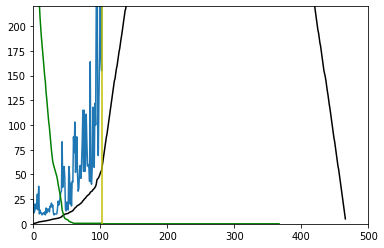

In [37]:
rolling_average = np.convolve(rewards, np.ones(100)/100)

plt.plot(rewards)
plt.plot(rolling_average, color='black')
plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TRAIN_END, color='y', linestyle='-')
plt.xlim( (0,EPISODES) )
plt.ylim( (0,220) )
plt.show()


envCartPole.close()

In [39]:
loss = [item['loss'][0] for item in dqn.loss]

Text(0.5, 0, 'EPISODS')

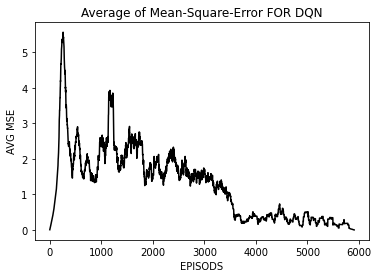

In [40]:
mse_average = np.convolve(loss, np.ones(100)/100)

#plt.plot(dqn.loss)
plt.plot(mse_average, color='black',)
plt.title('Average of Mean-Square-Error FOR DQN')
plt.ylabel('AVG MSE')
plt.xlabel('EPISODS')



Text(0.5, 0, 'EPISODS')

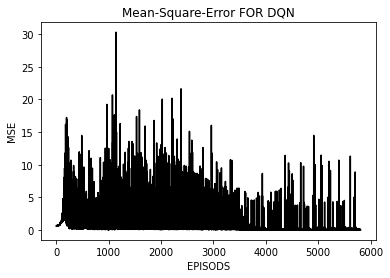

In [41]:
plt.plot(loss, color='black',)
plt.title('Mean-Square-Error FOR DQN')
plt.ylabel('MSE')
plt.xlabel('EPISODS')



Text(0.5, 0, 'EPISODS')

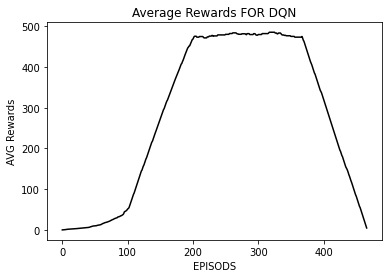

In [42]:
AVG_average = np.convolve(rewards, np.ones(100)/100)

plt.plot(AVG_average, color='black',)
plt.title('Average Rewards FOR DQN')
plt.ylabel('AVG Rewards')
plt.xlabel('EPISODS')



Text(0.5, 0, 'EPISODS')

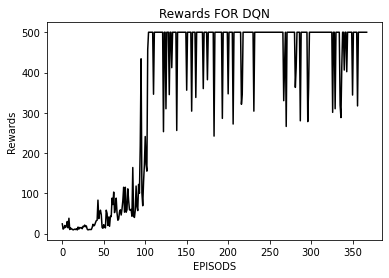

In [43]:
plt.plot(rewards, color='black',)
plt.title('Rewards FOR DQN')
plt.ylabel('Rewards')
plt.xlabel('EPISODS')



(-1.0, 2.0)

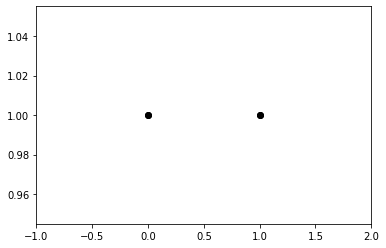

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# construct some data like what you have:
for key in ["0","1"]:
  
  mins = min(reward_per_action[key])
  maxes = max(reward_per_action[key])
  means = sum(reward_per_action[key]) / len(reward_per_action[key])
  
  # create stacked errorbars:
  plt.errorbar(np.arange(2), means, fmt='ok', lw=3)
  #plt.errorbar(np.arange(2), means, [means - mins, maxes - means],fmt='.k', ecolor='gray', lw=1)
plt.xlim(-1, 2)

Double DQN implementation

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 24)                120       
                                                                 
 dense_7 (Dense)             (None, 24)                600       
                                                                 
 dense_8 (Dense)             (None, 2)                 50        
                                                                 
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 24)                120       
                                                                 
 dense_10 (Dense)            (None

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


episode: 0   score: 38.0   memory length: 39   epsilon: 0.9617319426784903
episode: 1   score: 45.0   memory length: 85   epsilon: 0.9184732224159486
episode: 2   score: 17.0   memory length: 103   epsilon: 0.9020804841440176
episode: 3   score: 61.0   memory length: 165   epsilon: 0.847823709077432
episode: 4   score: 19.0   memory length: 185   epsilon: 0.8310273589761736
episode: 5   score: 35.0   memory length: 221   epsilon: 0.8016280363938307
episode: 6   score: 67.0   memory length: 289   epsilon: 0.7489039087598284
episode: 7   score: 24.0   memory length: 314   epsilon: 0.7304042691684477
episode: 8   score: 29.0   memory length: 344   epsilon: 0.7088069214222238
episode: 9   score: 9.0   memory length: 354   epsilon: 0.7017506636113059
episode: 10   score: 9.0   memory length: 364   epsilon: 0.6947646516921667
episode: 11   score: 10.0   memory length: 375   epsilon: 0.6871603381721801
episode: 12   score: 12.0   memory length: 388   epsilon: 0.6782806562448989
episode: 13   

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


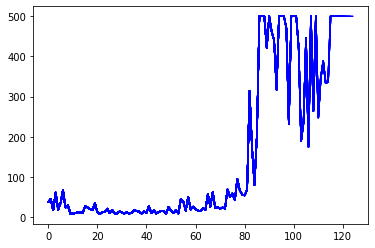

In [4]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential

EPISODES = 300


# Double DQN Agent for the Cartpole
# it uses Neural Network to approximate q function
# and replay memory & target q network
class DoubleDQNAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # these is hyper parameters for the Double DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.loss= []
        # initialize target model
        self.update_target_model()

        if self.load_model:
            self.model.load_weights("./save_model/cartpole_ddqn.h5")

    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(24, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # pick samples randomly from replay memory (with batch_size)
    def train_model(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(batch_size):
            update_input[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])

        target = self.model.predict(update_input)
        target_next = self.model.predict(update_target)
        target_val = self.target_model.predict(update_target)

        for i in range(self.batch_size):
            # like Q Learning, get maximum Q value at s'
            # But from target model
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                # the key point of Double DQN
                # selection of action is from model
                # update is from target model
                a = np.argmax(target_next[i])
                target[i][action[i]] = reward[i] + self.discount_factor * (
                    target_val[i][a])

        # make minibatch which includes target q value and predicted q value
        # and do the model fit!
        hist = self.model.fit(update_input, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)
        self.loss.append( hist.history )

if __name__ == "__main__":
    # In case of CartPole-v1, you can play until 500 time step
    env = gym.make('CartPole-v1')
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DoubleDQNAgent(state_size, action_size)

    scores, episodes = [], []
    reward_per_action = {"0":[],"1":[]}
    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            # get action for the current state and go one step in environment
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            reward_per_action[str(action)].append(reward)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
            reward = reward if not done or score == 499 else -100

            # save the sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            # every time step do the training
            agent.train_model()
            score += reward
            state = next_state

            if done:
                # every episode update the target model to be same with model
                agent.update_target_model()

                # every episode, plot the play time
                score = score if score == 500 else score + 100
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./cartpole_ddqn.png")
                print("episode:", e, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    sys.exit()

        # save the model
        if e % 50 == 0:
            agent.model.save_weights("./cartpole_ddqn.h5")

    import pickle as pk
    filehandler = open(b"Double_dqn.pk","wb")
    pk.dump(agent,filehandler)
    
    filehandler = open(b"tot_rewards.pk","wb")
    pk.dump(scores,filehandler)
    
    filehandler = open(b"reward_per_action.pk","wb")
    pk.dump(reward_per_action,filehandler)
    

In [6]:
import pickle as pk
filehandler = open(b"Double_dqn.pk","wb")
pk.dump(agent,filehandler)

filehandler = open(b"tot_rewards.pk","wb")
pk.dump(scores,filehandler)

filehandler = open(b"reward_per_action.pk","wb")
pk.dump(reward_per_action,filehandler)
    

INFO:tensorflow:Assets written to: ram://ae52913a-5eb2-431c-b30d-f721c2b9f78c/assets
INFO:tensorflow:Assets written to: ram://f95ee055-a61d-4eb6-b7dc-8b336e55346c/assets


Ploting For Double DQN

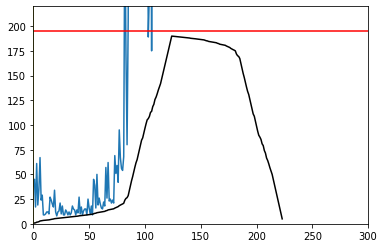

In [11]:
rolling_average = np.convolve(scores, np.ones(100)/100)

plt.plot(scores)
plt.plot(rolling_average, color='black')
plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range
#eps_graph = [200*x for x in epsilons]
#plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TRAIN_END, color='y', linestyle='-')
plt.xlim( (0,EPISODES) )
plt.ylim( (0,220) )
plt.show()


envCartPole.close()

In [14]:
loss = [item['loss'][0] for item in  agent.loss]

Text(0.5, 0, 'EPISODS')

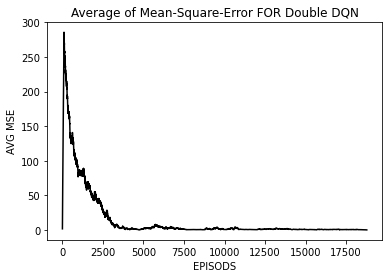

In [15]:
mse_average = np.convolve(loss, np.ones(100)/100)

#plt.plot(dqn.loss)
plt.plot(mse_average, color='black',)
plt.title('Average of Mean-Square-Error FOR Double DQN')
plt.ylabel('AVG MSE')
plt.xlabel('EPISODS')



Text(0.5, 0, 'EPISODS')

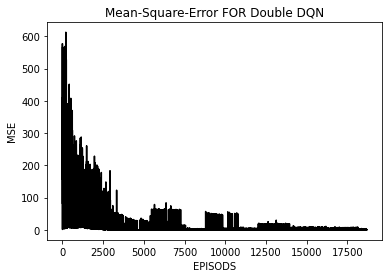

In [21]:
plt.plot(loss, color='black',)
plt.title('Mean-Square-Error FOR Double DQN')
plt.ylabel('MSE')
plt.xlabel('EPISODS')



Text(0.5, 0, 'EPISODS')

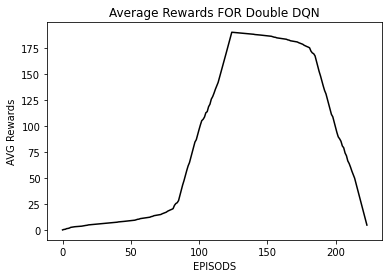

In [22]:
AVG_average = np.convolve(scores, np.ones(100)/100)

plt.plot(AVG_average, color='black',)
plt.title('Average Rewards FOR Double DQN')
plt.ylabel('AVG Rewards')
plt.xlabel('EPISODS')



Text(0.5, 0, 'EPISODS')

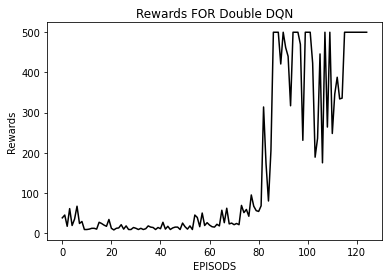

In [23]:
plt.plot(scores, color='black',)
plt.title('Rewards FOR Double DQN')
plt.ylabel('Rewards')
plt.xlabel('EPISODS')



(-1.0, 2.0)

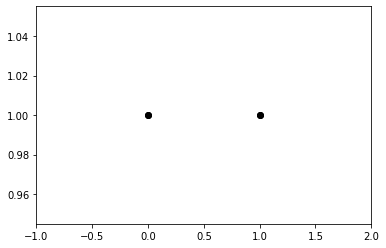

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# construct some data like what you have:
for key in reward_per_action.keys():
  
  mins = min(reward_per_action[key])
  maxes = max(reward_per_action[key])
  means = sum(reward_per_action[key]) / len(reward_per_action[key])
  
  # create stacked errorbars:
  plt.errorbar(np.arange(2), means, fmt='ok', lw=3)
  #plt.errorbar(np.arange(2), means, [means - mins, maxes - means],fmt='.k', ecolor='gray', lw=1)
plt.xlim(-1, 2)

In [ ]:
# Try Number @

Duael DQN Implementation

In [7]:
import gym
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import random
from itertools import count
import torch.nn.functional as F
from tensorboardX import SummaryWriter


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(4, 64)
        self.relu = nn.ReLU()
        self.fc_value = nn.Linear(64, 256)
        self.fc_adv = nn.Linear(64, 256)

        self.value = nn.Linear(256, 1)
        self.adv = nn.Linear(256, 2)

    def forward(self, state):
        y = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        advAverage = torch.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage

        return Q

    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item()


class Memory(object):
    def __init__(self, memory_size: int) -> None:
        self.memory_size = memory_size
        self.buffer = deque(maxlen=self.memory_size)

    def add(self, experience) -> None:
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size: int, continuous: bool = True):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if continuous:
            rand = random.randint(0, len(self.buffer) - batch_size)
            return [self.buffer[i] for i in range(rand, rand + batch_size)]
        else:
            indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
            return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()


env = gym.make('CartPole-v1')
n_state = env.observation_space.shape[0]
n_action = env.action_space.n

onlineQNetwork = QNetwork().to(device)
targetQNetwork = QNetwork().to(device)
targetQNetwork.load_state_dict(onlineQNetwork.state_dict())

optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=1e-4)

GAMMA = 0.99
EXPLORE = 20000
INITIAL_EPSILON = 0.1
FINAL_EPSILON = 0.0001
REPLAY_MEMORY = 50000
BATCH = 16

UPDATE_STEPS = 4

memory_replay = Memory(REPLAY_MEMORY)
cpochs = 4000
epsilon = INITIAL_EPSILON
learn_steps = 0
writer = SummaryWriter('logs/ddqn')
begin_learn = False

episode_reward = 0
rewards = []
total_loss = []
reward_per_action = {"0":[],"1":[],"2":[],"3":[]}
# onlineQNetwork.load_state_dict(torch.load('ddqn-policy.para'))

for epoch in range(cpochs):

    state = env.reset()
    episode_reward = 0
    done = False
    while not done:
        p = random.random()
        if p < epsilon:
            action = random.randint(0, 1)
        else:
            tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = onlineQNetwork.select_action(tensor_state)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        memory_replay.add((state, next_state, action, reward, done))
        if memory_replay.size() > 128:
            if begin_learn is False:
                print('learn begin!')
                begin_learn = True
            learn_steps += 1
            if learn_steps % UPDATE_STEPS == 0:
                targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
            batch = memory_replay.sample(BATCH, False)
            batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)

            batch_state = torch.FloatTensor(batch_state).to(device)
            batch_next_state = torch.FloatTensor(batch_next_state).to(device)
            batch_action = torch.FloatTensor(batch_action).unsqueeze(1).to(device)
            batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
            batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

            with torch.no_grad():
                onlineQ_next = onlineQNetwork(batch_next_state)
                targetQ_next = targetQNetwork(batch_next_state)
                online_max_action = torch.argmax(onlineQ_next, dim=1, keepdim=True)
                y = batch_reward + (1 - batch_done) * GAMMA * targetQ_next.gather(1, online_max_action.long())

            loss = F.mse_loss(onlineQNetwork(batch_state).gather(1, batch_action.long()), y)
            total_loss.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            writer.add_scalar('loss', loss.item(), global_step=learn_steps)

            if epsilon > FINAL_EPSILON:
                epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        if done:
            reward_per_action[str(action)].append(reward)
        
            rewards.append(episode_reward)
            break
        state = next_state

    writer.add_scalar('episode reward', episode_reward, global_step=epoch)
    if epoch % 10 == 0:
        torch.save(onlineQNetwork.state_dict(), 'ddqn-policy.para')
        print('Ep {}\tMoving average score: {:.2f}\t'.format(epoch, episode_reward))



Ep 0	Moving average score: 9.00	
Ep 10	Moving average score: 10.00	
learn begin!
Ep 20	Moving average score: 12.00	
Ep 30	Moving average score: 10.00	
Ep 40	Moving average score: 11.00	
Ep 50	Moving average score: 8.00	
Ep 60	Moving average score: 11.00	
Ep 70	Moving average score: 10.00	
Ep 80	Moving average score: 11.00	
Ep 90	Moving average score: 11.00	
Ep 100	Moving average score: 9.00	
Ep 110	Moving average score: 12.00	
Ep 120	Moving average score: 11.00	
Ep 130	Moving average score: 10.00	
Ep 140	Moving average score: 14.00	
Ep 150	Moving average score: 15.00	
Ep 160	Moving average score: 8.00	
Ep 170	Moving average score: 12.00	
Ep 180	Moving average score: 11.00	
Ep 190	Moving average score: 32.00	
Ep 200	Moving average score: 13.00	
Ep 210	Moving average score: 17.00	
Ep 220	Moving average score: 25.00	
Ep 230	Moving average score: 22.00	
Ep 240	Moving average score: 21.00	
Ep 250	Moving average score: 17.00	
Ep 260	Moving average score: 20.00	
Ep 270	Moving average score: 2

Ploting For Dueling DQN

Text(0.5, 0, 'EPISODS')

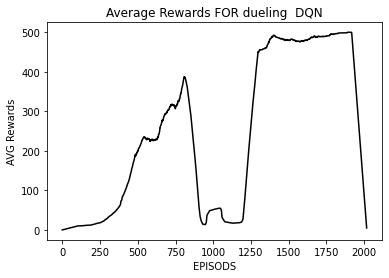

In [27]:
AVG_average = np.convolve(rewards, np.ones(100)/100)

plt.plot(AVG_average, color='black',)
plt.title('Average Rewards FOR dueling  DQN')
plt.ylabel('AVG Rewards')
plt.xlabel('EPISODS')



Text(0.5, 0, 'EPISODS')

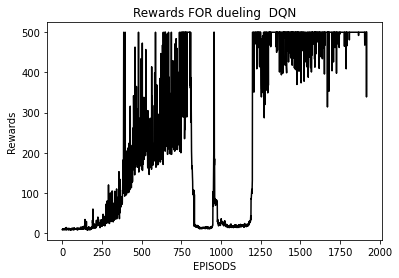

In [28]:
plt.plot(rewards, color='black',)
plt.title('Rewards FOR dueling  DQN')
plt.ylabel('Rewards')
plt.xlabel('EPISODS')



(-1.0, 2.0)

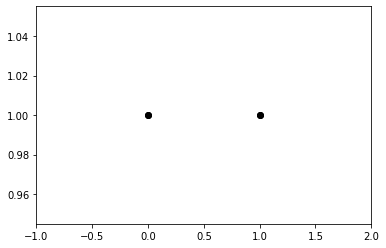

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# construct some data like what you have:
for key in ["0","1"]:
  
  mins = min(reward_per_action[key])
  maxes = max(reward_per_action[key])
  means = sum(reward_per_action[key]) / len(reward_per_action[key])
  
  # create stacked errorbars:
  plt.errorbar(np.arange(2), means, fmt='ok', lw=3)
  #plt.errorbar(np.arange(2), means, [means - mins, maxes - means],fmt='.k', ecolor='gray', lw=1)
plt.xlim(-1, 2)

Actor Network

In [587]:
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple


# Create the environment
env = gym.make("CartPole-v1")

# Set seed for experiment reproducibility
seed = 42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

In [588]:
actions_rewards = {} 
actions_rewards[0] = [] 
actions_rewards[1] = [] 

In [589]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions: int, 
      num_hidden_units: int):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [590]:
num_actions = env.action_space.n  # 2
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

In [591]:
def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Returns state, reward and done flag given an action."""

  state, reward, done, _ = env.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])

In [592]:
def run_episode(
    initial_state: tf.Tensor,  
    model: tf.keras.Model, 
    max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  """Runs a single episode to collect training data."""
  tf.compat.v1.enable_eager_execution()
  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
  score = 0
  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    score = score+1
    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)

    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)

    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]

    

    print(action)
    print("----------------------------------------------")

    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])

    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)
    #actions_rewards[int(action)].append(int(reward))
   

    #actions_rewards[action].append()
    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()

  

  return action_probs, values, rewards ,  int(score) , action

In [593]:
def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))

  return returns

In [594]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined actor-critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

In [595]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards, score , action = run_episode(
        initial_state, model, max_steps_per_episode) 

    # Calculate expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

    # Calculating loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  if(tf.cast(action,tf.int32) == 0):
    actions_rewards[0].append(int(episode_reward))
  else:
    actions_rewards[1].append(int(episode_reward))

  return episode_reward , loss , score

In [596]:
%%time

min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 1000

# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials
reward_threshold = 498
running_reward = 0

# Discount factor for future rewards
gamma = 0.99

Average_Rewards = []
episodes_reward_v = []
running_rewards = []
losses_rewards = []
scores = []

# Keep last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

with tqdm.trange(max_episodes) as t:
  for i in t:
    initial_state = tf.constant(env.reset(), dtype=tf.float32)
    episode_reward , loss , score = train_step(
        initial_state, model, optimizer, gamma, max_steps_per_episode)

    
    scores.append(score) ;
    episode_reward = int(episode_reward)
    losses_rewards.append(loss/i)
    episodes_reward.append(episode_reward)
    episodes_reward_v.append(episode_reward)
    Average_Rewards.append(np.sum(episodes_reward_v)/i)
    running_reward = statistics.mean(episodes_reward)
    running_rewards.append(running_reward)

    t.set_description(f'Episode {i}')
    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward, score = score)

    # Show average episode reward every 10 episodes
    if i % 10 == 0:
      pass # print(f'Episode {i}: average reward: {avg_reward}')

    if (running_reward > reward_threshold and i >= min_episodes_criterion)  :  
        break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')




  0%|          | 0/10000 [00:00<?, ?it/s]

Tensor("strided_slice:0", shape=(), dtype=int64)
----------------------------------------------
Tensor("while/strided_slice:0", shape=(), dtype=int64)
----------------------------------------------
Tensor("strided_slice:0", shape=(), dtype=int64)
----------------------------------------------
Tensor("while/strided_slice:0", shape=(), dtype=int64)
----------------------------------------------


<timed exec>:34: RuntimeWarning: divide by zero encountered in long_scalars
Episode 1197:  12%|█▏        | 1197/10000 [04:36<33:55,  4.33it/s, episode_reward=500, running_reward=500, score=tf.Tensor(500, shape=(), dtype=int32)]


Solved at episode 1197: average reward: 500.00!
Wall time: 4min 36s


No handles with labels found to put in legend.


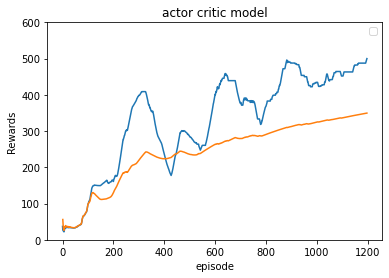

In [597]:
import matplotlib.pyplot as plt
plt.xlabel("episode")
plt.ylabel("Rewards")
ax = plt.gca()

ax.set_ylim([0, 600])
plt.title("actor critic model")
#plt.plot(episodes_reward_v , label = "Episodes Reward")
plt.legend(loc='best')
plt.plot(running_rewards  , label = "Runing Reward")
plt.plot(Average_Rewards  , label = "Average Rewards")

plt.show()

No handles with labels found to put in legend.


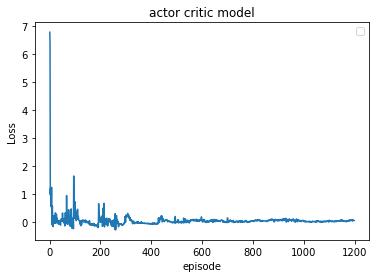

In [598]:
import matplotlib.pyplot as plt
plt.xlabel("episode")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.title("actor critic model")
plt.plot(losses_rewards , label = "Loss")

plt.show()


No handles with labels found to put in legend.


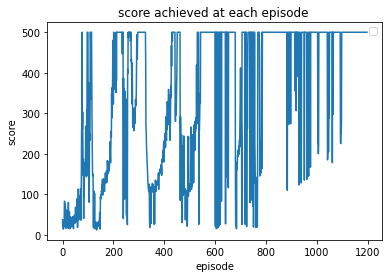

In [599]:

import matplotlib.pyplot as plt
plt.xlabel("episode")
plt.ylabel("score")
plt.legend(loc='best')
plt.title("score achieved at each episode ")
plt.plot(scores , label = "Loss")

plt.show()

No handles with labels found to put in legend.


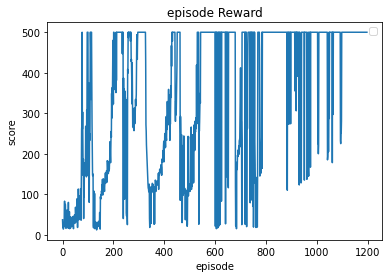

In [600]:
import matplotlib.pyplot as plt
plt.xlabel("episode")
plt.ylabel("score")
plt.legend(loc='best')
plt.title("episode Reward")
plt.plot(episodes_reward_v , label = "Episodes Reward")

plt.show()